In [1]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from matplotlib_venn import venn2

%matplotlib inline
warnings.filterwarnings("ignore")

/Users/yamauchi/miniconda3/envs/bitools_py3_dev/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append(os.path.join(Path().resolve(), '../../../gutan/scripts'))

In [3]:
from utils import get_samesubject_sampleids

In [4]:
p_ge_C = pd.read_csv("../data_output/htest_tp/ge.0.001.htest.0w.4w.C.tsv", sep="\t", header=0, index_col=0)
p_ge_T = pd.read_csv("../data_output/htest_tp/ge.0.001.htest.0w.4w.T.tsv", sep="\t", header=0, index_col=0)
p_ra_C = pd.read_csv("../data_output/htest_tp/ra.25.htest.0w.4w.C.tsv", sep="\t", header=0, index_col=0)
p_ra_T = pd.read_csv("../data_output/htest_tp/ra.25.htest.0w.4w.T.tsv", sep="\t", header=0, index_col=0)

ge = pd.read_csv("../data_inter/ge.0.001.tsv", sep="\t", header=0, index_col=0)
ra = pd.read_csv("../data_inter/ra.25.tsv", sep="\t", header=0, index_col=0)
me = pd.read_csv("../data_input/me.tsv", sep="\t", header=0, index_col=0)

# volcano plot

In [15]:
plt.rcParams["font.family"] = "Arial"

In [25]:
def plot_volcano(xs, ys, indexes, path_out_pdf, annotate=False):
    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys)
    lim = max(abs(xs.min()), xs.max()) * 1.1
    plt.xlim(-lim, lim)
    plt.tick_params(top='off', right='off')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    if annotate:
        for x, y, ind in zip(xs, ys, indexes):
            if y >= -np.log10(0.05):
                plt.annotate(ind, xy=(x, y))
    ymin_old, ymax_old = plt.ylim()
    xmin_old, xmax_old = plt.xlim()
    plt.hlines(y=-np.log10(0.05), xmin=xmin_old, xmax=xmax_old, linestyles='dashed')
    plt.vlines(x=0, ymin=-0.1, ymax=ymax_old, linestyles='dashed')
    plt.gca().set_xlim([xmin_old, xmax_old])
    plt.gca().set_ylim([-0.1, ymax_old])
    plt.savefig(path_out_pdf)
#     plt.clf()
    plt.show()

def calc_log2fc(df, mdf, mkey, mval1, mval2):
    _df = pd.DataFrame()
    
    (sids_mv1, sids_mv2), subject_ids = get_samesubject_sampleids(mdf, mkey, [mval1, mval2], return_subjectid=True)

    for ind in df.index:
        for sid1, sid2, sb in zip(sids_mv1, sids_mv2, subject_ids):
            val1 = df.loc[ind, sid1]
            val2 = df.loc[ind, sid2]
            fc = val1/val2
            _df.loc[ind, f"{sb}_{mval2}{mval1}"] = fc

    _df = np.log2(_df)
    _df = _df.fillna(0)
    _df = _df.replace(np.inf, df.max().max())
    _df = _df.replace(-np.inf, df.min().min())
    return _df.mean(axis=1)

def calc_hedges_g(df, mdf, mkey, mval1, mval2):
    s_out = pd.Series()
    for ind in df.index:
        vals1 = df.loc[ind, mdf.loc[mkey]==mval1].values
        vals2 = df.loc[ind, mdf.loc[mkey]==mval2].values

        n1 = len(vals1)
        n2 = len(vals2)
        s1 = np.std(vals1)
        s2 = np.std(vals2)

        s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
        d = (np.mean(vals2) - np.mean(vals1)) / s
        g = (1 - (3 / (4 * (n1 + n2 - 9)))) * d
        
        s_out.loc[ind] = g
    
    return s_out

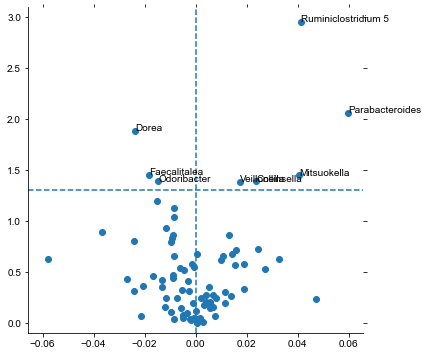

In [26]:
input_file = "../data_inter/ge.0.001.T.tsv"
metadata = "../data_inter/me.T.tsv"
path_out_pdf1 = "../data_output/htest_summary/volcanoplot.ge.0.001.T.hedges_g.2.pdf"
# path_out_pdf2 = "../data_output/htest_summary/volcanoplot.ra.25.C.log2fc.pdf"
mkey = "timepoint"
mval1 = "0w"
mval2 = "4w"

df = pd.read_csv(input_file, sep="\t", header=0, index_col=0)
mdf = pd.read_csv(metadata, sep="\t", header=0, index_col=0)

df_plot = pd.DataFrame()

df_plot["p_value"] = -np.log10(p_ge_T["wilcoxon"])

df_plot["effect_size"] = calc_hedges_g(df, mdf, mkey, mval1, mval2)
plot_volcano(df_plot["effect_size"], df_plot["p_value"], df.index, path_out_pdf1, annotate=True)

# df_plot["effect_size"] = calc_log2fc(df, mdf, mkey, mval1, mval2)
# plot_volcano(df_plot["effect_size"], df_plot["p_value"], df.index, path_out_pdf2)

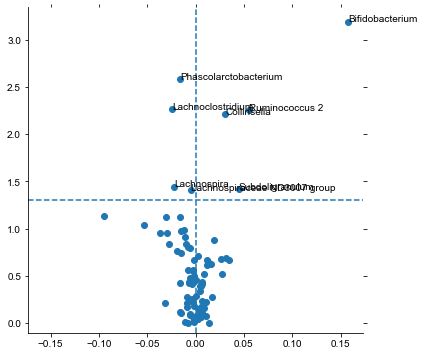

In [27]:
input_file = "../data_inter/ge.0.001.C.tsv"
metadata = "../data_inter/me.C.tsv"
path_out_pdf1 = "../data_output/htest_summary/volcanoplot.ge.0.001.C.hedges_g.2.pdf"
# path_out_pdf2 = "../data_output/htest_summary/volcanoplot.ra.25.C.log2fc.pdf"
mkey = "timepoint"
mval1 = "0w"
mval2 = "4w"

df = pd.read_csv(input_file, sep="\t", header=0, index_col=0)
mdf = pd.read_csv(metadata, sep="\t", header=0, index_col=0)

df_plot = pd.DataFrame()

df_plot["p_value"] = -np.log10(p_ge_C["wilcoxon"])

df_plot["effect_size"] = calc_hedges_g(df, mdf, mkey, mval1, mval2)
plot_volcano(df_plot["effect_size"], df_plot["p_value"], df.index, path_out_pdf1, annotate=True)

# df_plot["effect_size"] = calc_log2fc(df, mdf, mkey, mval1, mval2)
# plot_volcano(df_plot["effect_size"], df_plot["p_value"], df.index, path_out_pdf2)

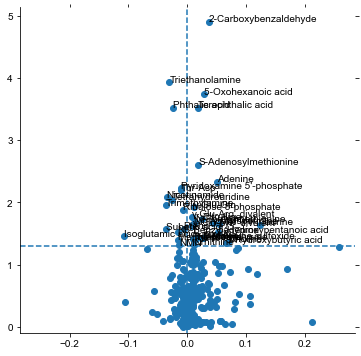

In [28]:
input_file = "../data_inter/ra.25.C.tsv"
metadata = "../data_inter/me.C.tsv"
path_out_pdf1 = "../data_output/htest_summary/volcanoplot.ra.25.C.hedges_g.2.pdf"
# path_out_pdf2 = "../data_output/htest_summary/volcanoplot.ra.25.C.log2fc.pdf"
mkey = "timepoint"
mval1 = "0w"
mval2 = "4w"

df = pd.read_csv(input_file, sep="\t", header=0, index_col=0)
mdf = pd.read_csv(metadata, sep="\t", header=0, index_col=0)

df_plot = pd.DataFrame()

df_plot["p_value"] = -np.log10(p_ra_C["wilcoxon"])

df_plot["effect_size"] = calc_hedges_g(df, mdf, mkey, mval1, mval2)
plot_volcano(df_plot["effect_size"], df_plot["p_value"], df.index, path_out_pdf1, annotate=True)

# df_plot["effect_size"] = calc_log2fc(df, mdf, mkey, mval1, mval2)
# plot_volcano(df_plot["effect_size"], df_plot["p_value"], df.index, path_out_pdf2)

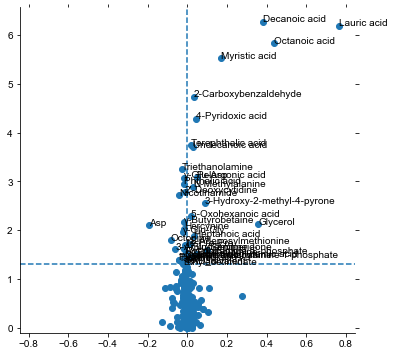

In [29]:
input_file = "../data_inter/ra.25.T.tsv"
metadata = "../data_inter/me.T.tsv"
path_out_pdf1 = "../data_output/htest_summary/volcanoplot.ra.25.T.hedges_g.2.pdf"
# path_out_pdf2 = "../data_output/htest_summary/volcanoplot.ra.25.C.log2fc.pdf"
mkey = "timepoint"
mval1 = "0w"
mval2 = "4w"

df = pd.read_csv(input_file, sep="\t", header=0, index_col=0)
mdf = pd.read_csv(metadata, sep="\t", header=0, index_col=0)

df_plot = pd.DataFrame()

df_plot["p_value"] = -np.log10(p_ra_T["wilcoxon"])

df_plot["effect_size"] = calc_hedges_g(df, mdf, mkey, mval1, mval2)
plot_volcano(df_plot["effect_size"], df_plot["p_value"], df.index, path_out_pdf1, annotate=True)

# df_plot["effect_size"] = calc_log2fc(df, mdf, mkey, mval1, mval2)
# plot_volcano(df_plot["effect_size"], df_plot["p_value"], df.index, path_out_pdf2)

In [30]:
p_ra_T.query("wilcoxon_f < 0.05")

,welch,mann_whitney,wilcoxon,pair_t,welch_f,mann_whitney_f,wilcoxon_f,pair_t_f,mann_whitneyGL,wilcoxonGL
2'-Deoxycytidine,6.929200e-03,6.069970e-03,1.644006e-03,1.699280e-03,2.702388e-01,1.721664e-01,0.036638,5.890836e-02,L,L
2-Carboxybenzaldehyde,1.194794e-09,3.940156e-09,1.821530e-05,1.194794e-09,3.727757e-07,3.073322e-07,0.001137,3.727757e-07,G,G
4-Pyridoxic acid,7.406533e-02,1.154715e-05,5.186422e-05,8.156229e-05,9.520766e-01,5.146729e-04,0.002697,6.361858e-03,G,G
Decanoic acid,4.316009e-05,2.367997e-10,5.388791e-07,3.795845e-05,6.732974e-03,7.388151e-08,0.000101,5.921518e-03,G,G
Lauric acid,3.358642e-04,2.111021e-09,6.484786e-07,3.258414e-04,2.619741e-02,2.195461e-07,0.000101,1.452322e-02,G,G
Myristic acid,1.043471e-01,6.952364e-05,2.976464e-06,1.034457e-01,9.520766e-01,2.711422e-03,0.000232,6.688197e-01,G,G
N-Methylalanine,7.749497e-02,7.055900e-02,1.284816e-03,3.005726e-03,9.520766e-01,7.591175e-01,0.030836,9.377865e-02,G,G
Nicotinamide,2.027482e-02,2.830856e-02,1.934760e-03,1.611965e-03,5.750675e-01,4.906817e-01,0.040243,5.890836e-02,L,L
Octanoic acid,6.635763e-05,1.950819e-09,1.469201e-06,7.350847e-05,6.901194e-03,2.195461e-07,0.000153,6.361858e-03,G,G
Pelargonic acid,4.793892e-02,1.481991e-02,8.074799e-04,2.280385e-02,9.520766e-01,3.545160e-01,0.023777,3.557401e-01,G,G


# ベン図

In [8]:
p_ge_C = pd.read_csv("../data_output/htest_tp/ge.0.001.htest.0w.4w.C.tsv", sep="\t", header=0, index_col=0)
p_ge_T = pd.read_csv("../data_output/htest_tp/ge.0.001.htest.0w.4w.T.tsv", sep="\t", header=0, index_col=0)
p_ra_C = pd.read_csv("../data_output/htest_tp/ra.25.htest.0w.4w.C.tsv", sep="\t", header=0, index_col=0)
p_ra_T = pd.read_csv("../data_output/htest_tp/ra.25.htest.0w.4w.T.tsv", sep="\t", header=0, index_col=0)

In [9]:
l_ge_sG_C = p_ge_C.query("wilcoxon < 0.05").query("wilcoxonGL == 'G'").index
l_ge_sG_T = p_ge_T.query("wilcoxon < 0.05").query("wilcoxonGL == 'G'").index
l_ra_sG_C = p_ra_C.query("wilcoxon < 0.05").query("wilcoxonGL == 'G'").index
l_ra_sG_T = p_ra_T.query("wilcoxon < 0.05").query("wilcoxonGL == 'G'").index

l_ge_sL_C = p_ge_C.query("wilcoxon < 0.05").query("wilcoxonGL == 'L'").index
l_ge_sL_T = p_ge_T.query("wilcoxon < 0.05").query("wilcoxonGL == 'L'").index
l_ra_sL_C = p_ra_C.query("wilcoxon < 0.05").query("wilcoxonGL == 'L'").index
l_ra_sL_T = p_ra_T.query("wilcoxon < 0.05").query("wilcoxonGL == 'L'").index

In [11]:
l_ge_sG_both = set(l_ge_sG_C) & set(l_ge_sG_T)
l_ge_sG_C_only = set(l_ge_sG_C) ^ l_ge_sG_both
l_ge_sG_T_only = set(l_ge_sG_T) ^ l_ge_sG_both

In [12]:
l_ge_sL_both = set(l_ge_sL_C) & set(l_ge_sL_T)
l_ge_sL_C_only = set(l_ge_sL_C) ^ l_ge_sL_both
l_ge_sL_T_only = set(l_ge_sL_T) ^ l_ge_sL_both

In [32]:
print(l_ge_sG_both)
print(l_ge_sG_C_only)
print(l_ge_sG_T_only)

{'Collinsella'}
{'Ruminococcus 2', 'Subdoligranulum', 'Bifidobacterium'}
{'Ruminiclostridium 5', 'Mitsuokella', 'Parabacteroides', 'Veillonella'}


In [33]:
print(l_ge_sL_both)
print(l_ge_sL_C_only)
print(l_ge_sL_T_only)

set()
{'Lachnospiraceae ND3007 group', 'Lachnospira', 'Lachnoclostridium', 'Phascolarctobacterium'}
{'Faecalitalea', 'Odoribacter', 'Dorea'}


In [40]:
l_ra_sL_C

Index(['Isoglutamic acid', 'Methyl sulfate', 'N6-Benzyladenine',
       'Nicotinamide', 'NMN', 'Phthalic acid', 'Pterin',
       'Pyridoxamine 5'-phosphate', 'Ribulose 5-phosphate', 'Suberic acid',
       'Tetrahydrouridine', 'Thr-Asp', 'Triethanolamine', 'Trimethylamine'],
      dtype='object')

In [41]:
l_ra_sL_T

Index(['2'-Deoxycytidine', '3-Amino-2-piperidone', 'AMP', 'Asp', 'Carnitine',
       'Cysteic acid', 'Ethylacetimidate', 'FAD_divalent', 'Hercynine',
       'Ile-Pro-Pro', 'N-Acetylglucosamine 1-phosphate', 'Nicotinamide',
       'Octopine', 'Phthalic acid', 'Picolinic acid',
       'Pyridoxamine 5'-phosphate', 'Ser-Glu', 'Taurine', 'Triethanolamine',
       'γ-Butyrobetaine', 'γ-Glu-Asp', 'γ-Glu-Gly', 'γ-Glu-Ser'],
      dtype='object')

In [34]:
l_ra_sG_both = set(l_ra_sG_C) & set(l_ra_sG_T)
l_ra_sG_C_only = set(l_ra_sG_C) ^ l_ra_sG_both
l_ra_sG_T_only = set(l_ra_sG_T) ^ l_ra_sG_both

In [35]:
l_ra_sL_both = set(l_ra_sL_C) & set(l_ra_sL_T)
l_ra_sL_C_only = set(l_ra_sL_C) ^ l_ra_sL_both
l_ra_sL_T_only = set(l_ra_sL_T) ^ l_ra_sL_both

In [36]:
print(l_ra_sG_both)
print(l_ra_sG_C_only)
print(l_ra_sG_T_only)

{'Terephthalic acid', '2-Carboxybenzaldehyde', 'S-Adenosylmethionine', '5-Oxohexanoic acid'}
{'Choline', 'γ-Glu-Ala', 'Thiaproline', 'γ-Glu-Lys_divalent', 'Adenine', 'Ornithine', 'N-Formylmethionine', 'N1-Acetylspermine', 'Taurine', 'Methionine sulfoxide', '3-Hydroxybutyric acid', '5-Hydroxypentanoic acid', 'Citrulline', 'γ-Glu-Gln', 'N6-Methyllysine', 'β-Ala', 'Met', 'γ-Glu-Arg_divalent', 'γ-Glu-Met'}
{'Pelargonic acid', 'Formiminoglutamic acid', 'Lauric acid', 'Octanoic acid', '3-Hydroxy-2-methyl-4-pyrone', 'N-Methylalanine', 'Glycerol', '4-Pyridoxic acid', 'Decanoic acid', 'Ethanolamine', 'Heptanoic acid', 'Undecanoic acid', 'Myristic acid', 'Nω-Methylarginine'}


In [37]:
print(l_ra_sL_both)
print(l_ra_sL_C_only)
print(l_ra_sL_T_only)

{'Triethanolamine', "Pyridoxamine 5'-phosphate", 'Nicotinamide', 'Phthalic acid'}
{'Isoglutamic acid', 'NMN', 'Trimethylamine', 'Tetrahydrouridine', 'Thr-Asp', 'Methyl sulfate', 'Pterin', 'Ribulose 5-phosphate', 'N6-Benzyladenine', 'Suberic acid'}
{"2'-Deoxycytidine", 'Carnitine', 'FAD_divalent', 'γ-Glu-Ser', 'Asp', '3-Amino-2-piperidone', 'Hercynine', 'Picolinic acid', 'Ethylacetimidate', 'γ-Butyrobetaine', 'Cysteic acid', 'Ser-Glu', 'Octopine', 'γ-Glu-Gly', 'N-Acetylglucosamine 1-phosphate', 'Ile-Pro-Pro', 'Taurine', 'AMP', 'γ-Glu-Asp'}


In [19]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14

In [20]:
!mkdir ../data_output/htest_venn

mkdir: ../data_output/htest_venn: File exists


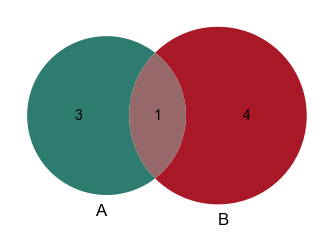

In [21]:
venn2(subsets=(len(l_ge_sG_C_only), len(l_ge_sG_T_only), len(l_ge_sG_both)), set_colors=('#2E7C70', '#A91826'), alpha = 1.0)
plt.savefig("../data_output/htest_venn/venn.ge.0.001.G.pdf")
plt.show()

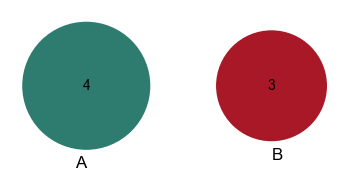

In [22]:
venn2(subsets=(len(l_ge_sL_C_only), len(l_ge_sL_T_only), len(l_ge_sL_both)), set_colors=('#2E7C70', '#A91826'), alpha = 1.0)
plt.savefig("../data_output/htest_venn/venn.ge.0.001.L.pdf")
plt.show()

In [23]:
p_ra_T.query("wilcoxon < 0.05").sort_values("wilcoxon").to_csv("hoge.tsv", sep="\t")

In [24]:
p_ra_T.query("wilcoxon < 0.05").query("wilcoxonGL == 'G'").shape

(18, 10)

In [25]:
p_ra_T.query("wilcoxon < 0.05").query("wilcoxonGL == 'L'").shape

(23, 10)

In [26]:
print(l_ra_sG_both)
print(l_ra_sL_both)

print(l_ra_sG_T_only)
print(l_ra_sL_T_only)

print(l_ra_sG_C_only)
print(l_ra_sL_C_only)

{'Terephthalic acid', '2-Carboxybenzaldehyde', 'S-Adenosylmethionine', '5-Oxohexanoic acid'}
{'Triethanolamine', "Pyridoxamine 5'-phosphate", 'Nicotinamide', 'Phthalic acid'}
{'Pelargonic acid', 'Formiminoglutamic acid', 'Lauric acid', 'Octanoic acid', '3-Hydroxy-2-methyl-4-pyrone', 'N-Methylalanine', 'Glycerol', '4-Pyridoxic acid', 'Decanoic acid', 'Ethanolamine', 'Heptanoic acid', 'Undecanoic acid', 'Myristic acid', 'Nω-Methylarginine'}
{"2'-Deoxycytidine", 'Carnitine', 'FAD_divalent', 'γ-Glu-Ser', 'Asp', '3-Amino-2-piperidone', 'Hercynine', 'Picolinic acid', 'Ethylacetimidate', 'γ-Butyrobetaine', 'Cysteic acid', 'Ser-Glu', 'Octopine', 'γ-Glu-Gly', 'N-Acetylglucosamine 1-phosphate', 'Ile-Pro-Pro', 'Taurine', 'AMP', 'γ-Glu-Asp'}
{'Choline', 'γ-Glu-Ala', 'Thiaproline', 'γ-Glu-Lys_divalent', 'Adenine', 'Ornithine', 'N-Formylmethionine', 'N1-Acetylspermine', 'Taurine', 'Methionine sulfoxide', '3-Hydroxybutyric acid', '5-Hydroxypentanoic acid', 'Citrulline', 'γ-Glu-Gln', 'N6-Methyllysine'

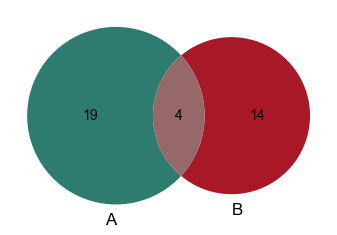

In [27]:
venn2(subsets=(len(l_ra_sG_C_only), len(l_ra_sG_T_only), len(l_ra_sG_both)), set_colors=('#2E7C70', '#A91826'), alpha = 1.0)
plt.savefig("../data_output/htest_venn/venn.ra.25.G.pdf")
plt.show()

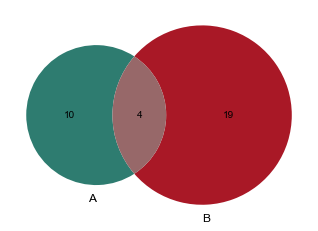

In [170]:
venn2(subsets=(len(l_ra_sL_C_only), len(l_ra_sL_T_only), len(l_ra_sL_both)), set_colors=('#2E7C70', '#A91826'), alpha = 1.0)
plt.savefig("../data_output/htest_venn/venn.ra.25.L.pdf")
plt.show()

In [203]:
l_ra_sG_C_only

{'3-Hydroxybutyric acid',
 '5-Hydroxypentanoic acid',
 'Adenine',
 'Choline',
 'Citrulline',
 'Met',
 'Methionine sulfoxide',
 'N-Formylmethionine',
 'N1-Acetylspermine',
 'N6-Methyllysine',
 'Ornithine',
 'Taurine',
 'Thiaproline',
 'β-Ala',
 'γ-Glu-Ala',
 'γ-Glu-Arg_divalent',
 'γ-Glu-Gln',
 'γ-Glu-Lys_divalent',
 'γ-Glu-Met'}

In [204]:
l_ra_sL_C_only

{'Isoglutamic acid',
 'Methyl sulfate',
 'N6-Benzyladenine',
 'NMN',
 'Pterin',
 'Ribulose 5-phosphate',
 'Suberic acid',
 'Tetrahydrouridine',
 'Thr-Asp',
 'Trimethylamine'}

In [205]:
l_ra_sG_T_only

{'3-Hydroxy-2-methyl-4-pyrone',
 '4-Pyridoxic acid',
 'Decanoic acid',
 'Ethanolamine',
 'Formiminoglutamic acid',
 'Glycerol',
 'Heptanoic acid',
 'Lauric acid',
 'Myristic acid',
 'N-Methylalanine',
 'Nω-Methylarginine',
 'Octanoic acid',
 'Pelargonic acid',
 'Undecanoic acid'}

In [206]:
l_ra_sL_T_only

{"2'-Deoxycytidine",
 '3-Amino-2-piperidone',
 'AMP',
 'Asp',
 'Carnitine',
 'Cysteic acid',
 'Ethylacetimidate',
 'FAD_divalent',
 'Hercynine',
 'Ile-Pro-Pro',
 'N-Acetylglucosamine 1-phosphate',
 'Octopine',
 'Picolinic acid',
 'Ser-Glu',
 'Taurine',
 'γ-Butyrobetaine',
 'γ-Glu-Asp',
 'γ-Glu-Gly',
 'γ-Glu-Ser'}

In [31]:
print(p_ra_C.loc["Taurine", "wilcoxon"])
print(p_ra_T.loc["Taurine", "wilcoxon"])

0.02271774835753083
0.04154586431450709
